# Project Explorer: Unsupervised Muon Tagging

This notebook scans and analyzes all files in the `unsupervided_muon_tagging` project directory to understand what data, code, and results we have.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tables
import json
from pathlib import Path
from collections import defaultdict

# Base directory
BASE_DIR = Path('../')
print(f"Exploring: {BASE_DIR.resolve()}")
print("=" * 80)

Exploring: /home/hpc/b129dc/b129dc28/project/unsupervided_muon_tagging


## 1. Directory Structure

Let's first understand the overall structure of the project.

In [11]:
def scan_directory_tree(base_path, exclude_patterns=None, max_depth=3):
    """
    Recursively scan directory and return file statistics.
    """
    if exclude_patterns is None:
        exclude_patterns = ['.git', '__pycache__', '.ipynb_checkpoints', 'animal_images']
    
    file_stats = defaultdict(lambda: {'count': 0, 'total_size': 0, 'files': []})
    dir_structure = {}
    
    def should_exclude(path_str):
        return any(pattern in path_str for pattern in exclude_patterns)
    
    def scan_recursive(path, depth=0):
        if depth > max_depth:
            return
        
        try:
            items = sorted(path.iterdir())
        except PermissionError:
            return
        
        for item in items:
            if should_exclude(str(item)):
                continue
            
            if item.is_file():
                size = item.stat().st_size
                ext = item.suffix or 'no_extension'
                
                file_stats[ext]['count'] += 1
                file_stats[ext]['total_size'] += size
                file_stats[ext]['files'].append({
                    'path': str(item.relative_to(base_path)),
                    'size': size,
                    'name': item.name
                })
            
            elif item.is_dir():
                scan_recursive(item, depth + 1)
    
    scan_recursive(base_path)
    return dict(file_stats)

# Scan the project
file_stats = scan_directory_tree(BASE_DIR)

# Display summary
print("\n" + "=" * 80)
print("FILE TYPE SUMMARY")
print("=" * 80)
print(f"{'Extension':<15} {'Count':<10} {'Total Size':<20} {'Avg Size'}")
print("-" * 80)

for ext, stats in sorted(file_stats.items(), key=lambda x: x[1]['total_size'], reverse=True):
    total_mb = stats['total_size'] / (1024 * 1024)
    avg_mb = total_mb / stats['count']
    print(f"{ext:<15} {stats['count']:<10} {total_mb:<20.2f} MB {avg_mb:.2f} MB")


FILE TYPE SUMMARY
Extension       Count      Total Size           Avg Size
--------------------------------------------------------------------------------
.h5             162        550.17               MB 3.40 MB
.gz             1          364.28               MB 364.28 MB
.ipynb          5          0.19                 MB 0.04 MB
.npz            1          0.19                 MB 0.19 MB
.dat            1          0.03                 MB 0.03 MB


## 2. Data Directory Analysis

Explore what's in the `data/` directory.

In [12]:
data_dir = BASE_DIR / 'data'

print("=" * 80)
print("DATA DIRECTORY CONTENTS")
print("=" * 80)

if data_dir.exists():
    for item in sorted(data_dir.iterdir()):
        if item.name == 'animal_images':
            continue
        
        if item.is_dir():
            n_files = len(list(item.glob('*')))
            total_size = sum(f.stat().st_size for f in item.glob('*') if f.is_file())
            print(f"\n📁 {item.name}/")
            print(f"   Files: {n_files}")
            print(f"   Total size: {total_size / (1024**3):.2f} GB")
            
            # Show first few files
            files = sorted(item.glob('*'))[:5]
            for f in files:
                if f.is_file():
                    print(f"   - {f.name} ({f.stat().st_size / (1024**2):.1f} MB)")
            if n_files > 5:
                print(f"   ... and {n_files - 5} more files")
        
        elif item.is_file():
            size_mb = item.stat().st_size / (1024**2)
            print(f"\n📄 {item.name} ({size_mb:.2f} MB)")
else:
    print("Data directory not found!")

DATA DIRECTORY CONTENTS

📁 .ipynb_checkpoints/
   Files: 1
   Total size: 0.00 GB
   - FC_PixPos-checkpoint.dat (0.0 MB)

📄 FC_PixPos.dat (0.03 MB)

📁 flashcam/
   Files: 163
   Total size: 0.89 GB
   - flashcam_run178799_full.tar.gz (364.3 MB)
   - flashcam_run178799_full_000.h5 (3.3 MB)
   - flashcam_run178799_full_001.h5 (3.3 MB)
   - flashcam_run178799_full_002.h5 (3.3 MB)
   - flashcam_run178799_full_003.h5 (3.3 MB)
   ... and 158 more files


## 3. Analyze HDF5 Files

Look inside the FlashCam HDF5 files to understand their structure and content.

In [13]:
flashcam_dir = BASE_DIR / 'data' / 'flashcam'

print("=" * 80)
print("HDF5 FILE ANALYSIS")
print("=" * 80)

if flashcam_dir.exists():
    h5_files = sorted(flashcam_dir.glob('*.h5'))
    print(f"\nFound {len(h5_files)} HDF5 files")
    
    if h5_files:
        # Analyze first file in detail
        sample_file = h5_files[0]
        print(f"\nAnalyzing sample file: {sample_file.name}")
        print("-" * 80)
        
        with tables.open_file(sample_file, 'r') as f:
            print("\nDatasets found:")
            for node in f.root:
                if isinstance(node, tables.Array):
                    print(f"  - {node.name}:")
                    print(f"      Shape: {node.shape}")
                    print(f"      Dtype: {node.dtype}")
                    print(f"      Size: {node.size_in_memory / (1024**2):.2f} MB")
                    
                    # Sample statistics
                    if node.name == 'images':
                        sample_img = node[0]
                        print(f"      Sample image stats:")
                        print(f"        Min: {np.nanmin(sample_img):.6f}")
                        print(f"        Max: {np.nanmax(sample_img):.6f}")
                        print(f"        Mean: {np.nanmean(sample_img):.6f}")
                        print(f"        NaN pixels: {np.isnan(sample_img).sum()} / {sample_img.size} "
                              f"({np.isnan(sample_img).sum() / sample_img.size * 100:.1f}%)")
        
        # Statistics across all files
        print("\n" + "=" * 80)
        print("STATISTICS ACROSS ALL HDF5 FILES")
        print("=" * 80)
        
        total_images = 0
        file_sizes = []
        
        for h5_file in h5_files[:10]:  # Sample first 10 files
            with tables.open_file(h5_file, 'r') as f:
                if 'images' in f.root:
                    total_images += len(f.root.images)
                    file_sizes.append(h5_file.stat().st_size / (1024**2))
        
        print(f"\nSampled {len(file_sizes)} files:")
        print(f"  Total images in sample: {total_images}")
        print(f"  Average images per file: {total_images / len(file_sizes):.0f}")
        print(f"  Average file size: {np.mean(file_sizes):.2f} MB")
        print(f"  Total file size (sample): {np.sum(file_sizes):.2f} MB")
        
        # Estimate total
        estimated_total = (total_images / len(file_sizes)) * len(h5_files)
        print(f"\n  Estimated total images in all {len(h5_files)} files: {estimated_total:.0f}")
else:
    print("FlashCam directory not found!")

HDF5 FILE ANALYSIS

Found 162 HDF5 files

Analyzing sample file: flashcam_run178799_full_000.h5
--------------------------------------------------------------------------------

Datasets found:
  - event_id:
      Shape: (10000,)
      Dtype: int64
      Size: 0.08 MB
  - event_nr:
      Shape: (10000,)
      Dtype: int64
      Size: 0.08 MB
  - images:
      Shape: (10000, 56, 56)
      Dtype: float32
      Size: 119.63 MB
      Sample image stats:
        Min: 0.000000
        Max: 20.666313
        Mean: 0.053036
        NaN pixels: 1372 / 3136 (43.8%)
  - n_pixels:
      Shape: (10000,)
      Dtype: int32
      Size: 0.04 MB
  - total_charge:
      Shape: (10000,)
      Dtype: float32
      Size: 0.04 MB

STATISTICS ACROSS ALL HDF5 FILES

Sampled 10 files:
  Total images in sample: 100000
  Average images per file: 10000
  Average file size: 3.29 MB
  Total file size (sample): 32.86 MB

  Estimated total images in all 162 files: 1620000


## 4. Visualize Sample Images

Show some random images from the HDF5 files.

SAMPLE IMAGES FROM HDF5 FILES


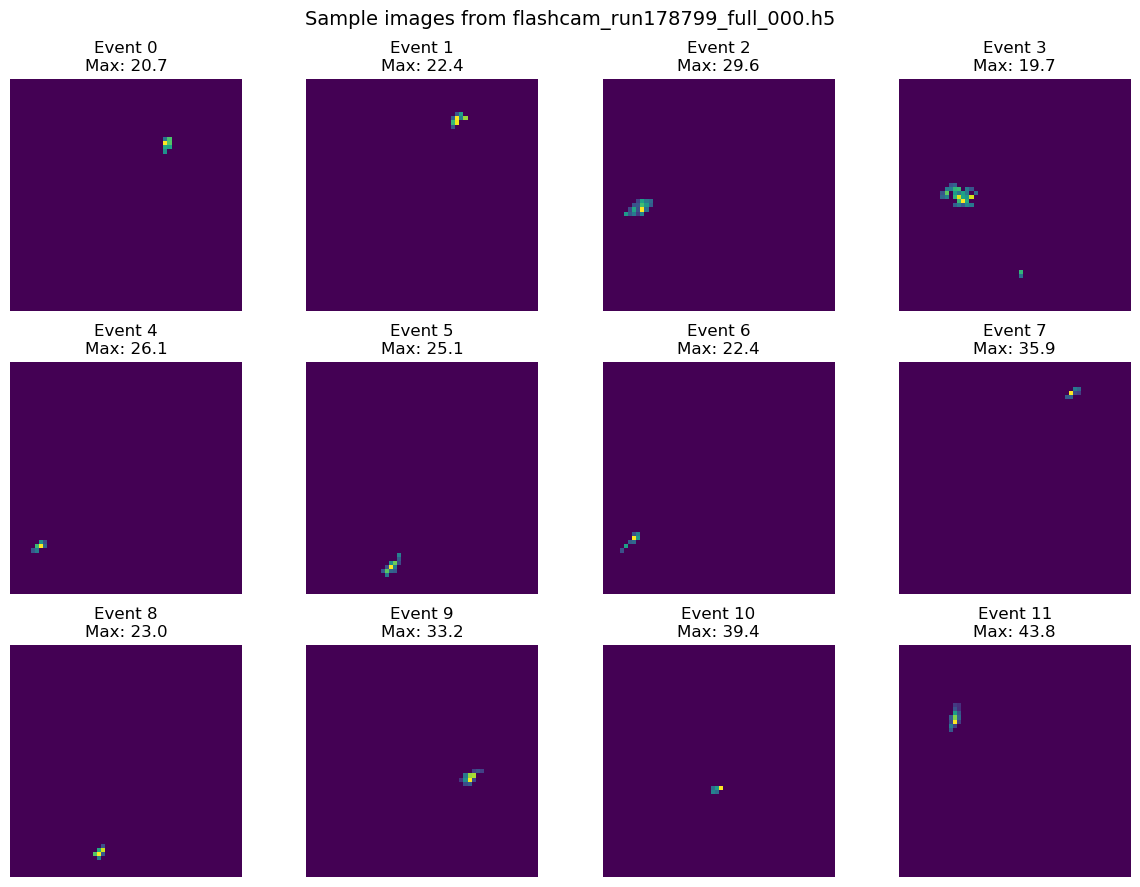


Image statistics (first 12 events):
  Non-zero pixels per image: 11.8 ± 7.3
  Mean intensity: 0.0475
  Max intensity: 43.76


In [14]:
if flashcam_dir.exists() and h5_files:
    print("=" * 80)
    print("SAMPLE IMAGES FROM HDF5 FILES")
    print("=" * 80)
    
    # Load images from first file
    with tables.open_file(h5_files[0], 'r') as f:
        images = f.root.images[:12]  # First 12 images
    
    # Replace NaN with 0 for visualization
    images = np.nan_to_num(images, nan=0.0)
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.flatten()
    
    for i, img in enumerate(images):
        axes[i].imshow(img, cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Event {i}\nMax: {img.max():.1f}')
    
    plt.suptitle(f'Sample images from {h5_files[0].name}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nImage statistics (first 12 events):")
    print(f"  Non-zero pixels per image: {(images > 0).sum(axis=(1,2)).mean():.1f} ± {(images > 0).sum(axis=(1,2)).std():.1f}")
    print(f"  Mean intensity: {images.mean():.4f}")
    print(f"  Max intensity: {images.max():.2f}")

## 5. Code Directory Analysis

Examine notebooks and scripts in the code directory.

In [15]:
code_dir = BASE_DIR / 'code'

print("=" * 80)
print("CODE DIRECTORY CONTENTS")
print("=" * 80)

if code_dir.exists():
    notebooks = sorted(code_dir.glob('*.ipynb'))
    scripts = sorted(code_dir.glob('*.py'))
    
    print(f"\nFound {len(notebooks)} notebooks:")
    for nb in notebooks:
        size_mb = nb.stat().st_size / (1024**2)
        print(f"  📓 {nb.name} ({size_mb:.2f} MB)")
        
        # Try to read notebook metadata
        try:
            with open(nb, 'r') as f:
                nb_data = json.load(f)
                n_cells = len(nb_data.get('cells', []))
                print(f"      Cells: {n_cells}")
                
                # Count code vs markdown
                code_cells = sum(1 for c in nb_data.get('cells', []) if c.get('cell_type') == 'code')
                markdown_cells = sum(1 for c in nb_data.get('cells', []) if c.get('cell_type') == 'markdown')
                print(f"      Code: {code_cells}, Markdown: {markdown_cells}")
        except:
            pass
    
    if scripts:
        print(f"\nFound {len(scripts)} Python scripts:")
        for script in scripts:
            size_kb = script.stat().st_size / 1024
            print(f"  🐍 {script.name} ({size_kb:.1f} KB)")
else:
    print("Code directory not found!")

CODE DIRECTORY CONTENTS

Found 5 notebooks:
  📓 Untitled.ipynb (0.00 MB)
      Cells: 1
      Code: 1, Markdown: 0
  📓 flashcam_clustering.ipynb (0.10 MB)
      Cells: 46
      Code: 28, Markdown: 18
  📓 project_explorer.ipynb (0.02 MB)
      Cells: 18
      Code: 9, Markdown: 9
  📓 tutorial.ipynb (0.04 MB)
      Cells: 76
      Code: 48, Markdown: 28
  📓 unsupervised_image_clustering.ipynb (0.03 MB)
      Cells: 38
      Code: 24, Markdown: 14


## 6. Results Directory Analysis

Check what results have been saved.

In [16]:
results_dir = BASE_DIR / 'results'

print("=" * 80)
print("RESULTS DIRECTORY CONTENTS")
print("=" * 80)

if results_dir.exists():
    result_files = sorted(results_dir.glob('*'))
    
    if result_files:
        print(f"\nFound {len(result_files)} result files:")
        for rf in result_files:
            if rf.is_file():
                size_mb = rf.stat().st_size / (1024**2)
                print(f"\n  📊 {rf.name} ({size_mb:.2f} MB)")
                
                # Try to load and analyze
                if rf.suffix == '.npz':
                    data = np.load(rf)
                    print(f"      Arrays: {list(data.keys())}")
                    for key in data.keys():
                        arr = data[key]
                        print(f"        {key}: shape={arr.shape}, dtype={arr.dtype}")
    else:
        print("\nResults directory is empty")
else:
    print("\nResults directory not found!")

RESULTS DIRECTORY CONTENTS

Found 1 result files:

  📊 cluster_assignments_k5.npz (0.19 MB)
      Arrays: ['kmeans_train', 'kmeans_test', 'gmm_train', 'gmm_test', 'event_nr_train', 'event_nr_test']
        kmeans_train: shape=(7759,), dtype=int32
        kmeans_test: shape=(1937,), dtype=int32
        gmm_train: shape=(7759,), dtype=int64
        gmm_test: shape=(1937,), dtype=int64
        event_nr_train: shape=(7759,), dtype=int64
        event_nr_test: shape=(1937,), dtype=int64


## 7. Other Files

Check for any other relevant files (config files, documentation, etc.)

In [17]:
print("=" * 80)
print("OTHER FILES IN PROJECT ROOT")
print("=" * 80)

for item in sorted(BASE_DIR.iterdir()):
    if item.name in ['data', 'code', 'results']:
        continue
    
    if item.is_file():
        size = item.stat().st_size
        if size < 1024:
            size_str = f"{size} B"
        elif size < 1024**2:
            size_str = f"{size/1024:.1f} KB"
        else:
            size_str = f"{size/(1024**2):.1f} MB"
        
        print(f"  {item.name} ({size_str})")
        
        # Show first few lines if it's a text file
        if item.suffix in ['.txt', '.md', '.py', '.sh', '.dat']:
            try:
                with open(item, 'r') as f:
                    lines = f.readlines()[:3]
                    for line in lines:
                        print(f"    {line.rstrip()}")
                if len(lines) > 3:
                    print("    ...")
            except:
                pass

OTHER FILES IN PROJECT ROOT


## 8. Summary Report

In [18]:
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

# Count files by type
h5_count = len(list(flashcam_dir.glob('*.h5'))) if flashcam_dir.exists() else 0
nb_count = len(list(code_dir.glob('*.ipynb'))) if code_dir.exists() else 0
result_count = len(list(results_dir.glob('*'))) if results_dir.exists() else 0

print(f"\n📁 Project: unsupervided_muon_tagging")
print(f"   Location: {BASE_DIR.resolve()}")
print(f"\n📊 Data:")
print(f"   - HDF5 files: {h5_count}")
if h5_count > 0:
    total_size = sum(f.stat().st_size for f in flashcam_dir.glob('*.h5')) / (1024**3)
    print(f"   - Total size: {total_size:.2f} GB")
    print(f"   - Estimated total events: {estimated_total:.0f}" if 'estimated_total' in locals() else "")

print(f"\n💻 Code:")
print(f"   - Notebooks: {nb_count}")

print(f"\n📈 Results:")
print(f"   - Saved files: {result_count}")

print(f"\n✅ Project appears to be set up for:")
print(f"   1. Processing FlashCam telescope images")
print(f"   2. Applying unsupervised learning (clustering)")
print(f"   3. Identifying muon ring signatures")

print("\n" + "=" * 80)


PROJECT SUMMARY

📁 Project: unsupervided_muon_tagging
   Location: /home/hpc/b129dc/b129dc28/project/unsupervided_muon_tagging

📊 Data:
   - HDF5 files: 162
   - Total size: 0.54 GB
   - Estimated total events: 1620000

💻 Code:
   - Notebooks: 5

📈 Results:
   - Saved files: 1

✅ Project appears to be set up for:
   1. Processing FlashCam telescope images
   2. Applying unsupervised learning (clustering)
   3. Identifying muon ring signatures

